# Sem3 ETS, кросс-валидация, тест Бокса-Кокса

## ETS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import boxcox
from ts_plot import plot_ts
import pandas_datareader as pdr
import datetime

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,5)


In [6]:
def demo_ets(T=200, level_type='A', trend_type='A', season_type='A', seasonal_periods=12):
    time = np.arange(T)
    L = 50 + time * 0.2
    if trend_type == 'A':
        trend = 0.1 * time
    elif trend_type == 'M':
        trend = 1 + 0.05 * time
    season_index = time % seasonal_periods
    base_season = np.sin(2*np.pi*season_index / seasonal_periods)
    if season_type == 'A':
        season = 5 * base_season
    elif season_type == 'M':
        season = 1 + 0.8 * base_season

    if level_type == 'A':
        base = L
    else:
        base = 1 + (L - L.min()) / L.max()

    y = base.copy()
    if trend_type == 'A':
        y = y + trend
    else:
        y = y * trend

    if season_type == 'A':
        y = y + season
    else:
        y = y * season

    plt.figure(figsize=(12, 5))
    plt.plot(y, label=f'ETS({level_type},{trend_type},{season_type})', linewidth=2)
    plt.grid(alpha=0.25)
    plt.legend()
    plt.title(f'ETS({level_type}, {trend_type}, {season_type})')
    plt.tight_layout()
    plt.show()

    return y

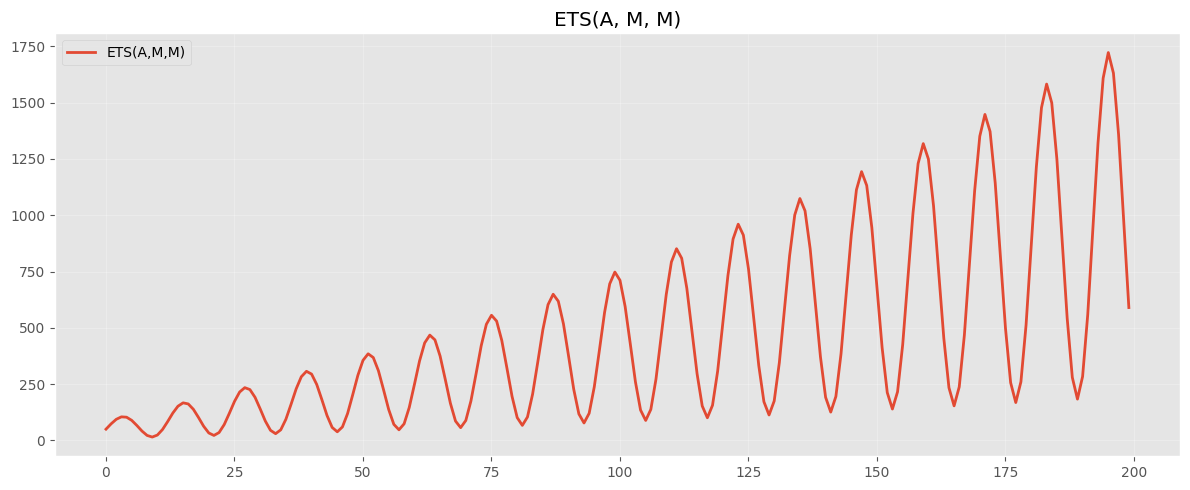

In [7]:
x= demo_ets(T=200, level_type='A', trend_type='M', season_type='M', seasonal_periods=12)

In [8]:
def ets_AAN(alpha, beta, l0, b0, sigma2, y):
    T = len(y)
    l_prev = l0
    b_prev = b0
    errors = np.zeros(T)

    for t in range(1, T):
        y_hat = l_prev + b_prev
        eps = y[t] - y_hat
        errors[t] = eps

        l_prev = l_prev + b_prev + alpha * eps
        b_prev = b_prev + beta  * eps

    nll = (T/2)*np.log(2 * np.pi * sigma2) + (1/(2 * sigma2)) * np.sum(errors**2)
    return nll

def ets_MMN(alpha, beta, l0, b0, sigma2, y):

    T = len(y)
    l = l0
    b = b0

    errors = np.zeros(T)

    for t in range(1, T):
        y_hat = l * b

        eps = (y[t] / y_hat) - 1
        errors[t] = eps

        l = y_hat * (1 + alpha * eps)

        b = b * (1 + beta * eps)

    nll = (T/2) * np.log(2*np.pi*sigma2) \
        + (1/(2*sigma2)) * np.sum(errors**2)

    return nll

In [9]:
np.random.seed(322)

# y = sm.datasets.sunspots.load_pandas().data['SUNACTIVITY'].values.astype(float)

y = pdr.DataReader('SP500', 'fred', datetime.datetime(1960, 1, 1),datetime.datetime(2024, 1, 1))['SP500'].dropna().values.astype(float)


# T = 1000
# cauchy_noise = np.random.standard_cauchy(T)
# cauchy_noise = np.clip(cauchy_noise, -500, 500)
# y = (0.5 * np.arange(T)+ 20 * np.sin(np.arange(T)/7)+ 15 * np.sin(np.arange(T)/17) + cauchy_noise * 10)
# y = y.astype(float)


# T = 400
# l0 = 100
# growth = 1.015
# noise_level = 0.03
# y = np.zeros(T)
# y[0] = l0
# for t in range(1, T):
#     eps = noise_level * np.random.normal()
#     y[t] = y[t-1] * growth * (1 + eps)

# y = y.astype(float)

# print(len(y))


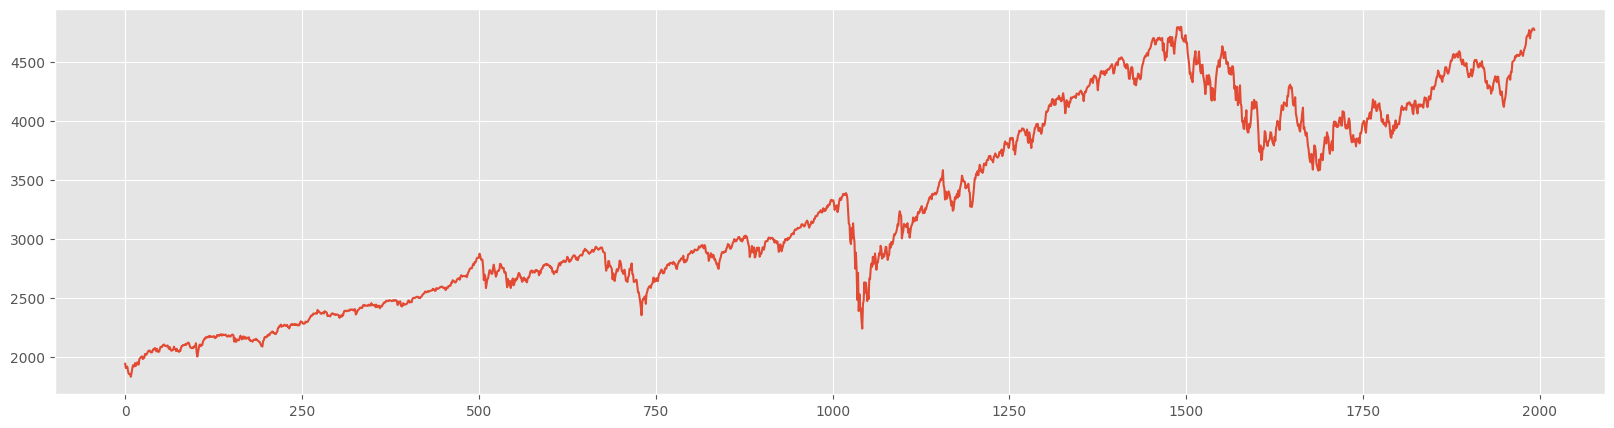

In [10]:
plt.plot(y)

In [12]:
alpha_vals = np.linspace(0.001, 0.999, 120)
beta_vals  = np.linspace(0.001, 0.999, 120)

A, B = np.meshgrid(alpha_vals, beta_vals)
Z = np.zeros_like(A)

l0 = y[0]
b0 = y[1] - y[0]
sigma2 = 2.0

for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        Z[i, j] = ets_MMN(A[i, j], B[i, j], l0, b0, sigma2,y)

Z_MIN = 0
Z_MAX = 5990

if Z_MAX is None:
    Z_plot = Z
    zaxis_range = None
else:
    Z_plot = np.clip(Z, Z_MIN, Z_MAX)
    zaxis_range = [Z_MIN, Z_MAX]

surface = go.Surface(x=A, y=B, z=Z_plot, colorscale='Turbo')
fig = go.Figure(data=[surface])

scene_dict = dict(xaxis_title='alpha',yaxis_title='beta', zaxis_title='Negative log-likelihood')

if zaxis_range is not None:
    scene_dict['zaxis'] = dict(range=zaxis_range)

fig.update_layout(title='ETS(A,A,N) loss surface over (alpha, beta) — dataset', scene=scene_dict, width=1100,height=900)

fig.show()

/var/folders/69/6__5j9xj5kv9jsdhz1s12l_40000gn/T/ipykernel_28769/4131356244.py:27: RuntimeWarning:

overflow encountered in scalar multiply



# Оценивание ETS

In [4]:
df = pd.DataFrame(y, columns=['data'])
df

,data
0,1940.24
1,1939.38
2,1903.03
3,1912.53
4,1915.45
...,...
1989,4754.63
1990,4774.75
1991,4781.58
1992,4783.35


In [ ]:
plot_ts([{'data': df['data'], 'name': 'sun'}], title_text = 'sun', one=False, show_acf = True, show_pacf = True, lags = 150)

In [ ]:
class ETS:
    def __init__(self, trend=None, seasonal=None, seasonal_periods=None,
                 damped_trend=False, use_boxcox=False,
                 initialization_method='estimated'):

        self.trend = trend                  # 'add' -'mul' - None
        self.seasonal = seasonal            # 'add' - 'mul' - None
        self.seasonal_periods = seasonal_periods
        self.damped_trend = damped_trend
        self.use_boxcox = use_boxcox
        self.initialization_method = initialization_method

        self.y_hat = None
        self.fit_res = None
        self.level = None
        self.trend_comp = None
        self.season_comp = None


    def fit(self, y):
        y = pd.Series(y).astype(float)

        model = ExponentialSmoothing(
            y,
            trend=self.trend,
            damped_trend=self.damped_trend,
            seasonal=self.seasonal,
            seasonal_periods=self.seasonal_periods,
            initialization_method=self.initialization_method,
            use_boxcox=self.use_boxcox
        )

        fit = model.fit(optimized=True, remove_bias=True)
        self.fit_res = fit

        self.level = np.asarray(fit.level)
        self.trend_comp = np.asarray(fit.trend) if self.trend else None
        self.season_comp = np.asarray(fit.season) if self.seasonal else None
        self.y_hat = (self.level + (self.trend_comp if self.trend_comp is not None else 0) + (self.season_comp if self.season_comp is not None else 0)
)

        return self

    def predict(self, h=1):


        if self.fit_res is None:
            raise RuntimeError('Сначала вызови fit(y).')

        y_fc = self.fit_res.forecast(h)


        def _to_series(arr):
            if arr is None:
                return None
            return pd.Series(arr, index=y_fc.index)

        last_l = float(self.level[-1])
        if self.trend_comp is not None:
            last_b = float(self.trend_comp[-1])
        else:
            last_b = 0.0

        level_fc = np.zeros(h)
        trend_fc = np.zeros(h) if self.trend_comp is not None else None

        phi = self.fit_res.params.get('damping_trend', 1.0) if self.damped_trend else 1.0

        b_cur = last_b
        l_cur = last_l
        for i in range(h):
            l_cur = l_cur + phi * b_cur
            if self.damped_trend:
                b_cur = phi * b_cur
            level_fc[i] = l_cur
            if trend_fc is not None:
                trend_fc[i] = b_cur

        season_fc = None
        if self.season_comp is not None and self.seasonal_periods is not None:
            m = self.seasonal_periods
            last_season = self.season_comp[-m:]
            reps = int(np.ceil(h / m))
            season_fc = np.tile(last_season, reps)[:h]


        return {'y_forecast': y_fc, 'level_fc': _to_series(level_fc), 'trend_fc': _to_series(trend_fc), 'season_fc': _to_series(season_fc)}

In [ ]:
model = ETS(trend='mul', seasonal= None, seasonal_periods = 11)
model.fit(y[:-100])

fc = model.predict(h=100)

/Users/nalliennallien/anaconda3/envs/sheshkin/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning:

overflow encountered in matmul



In [ ]:
plot_ts([{'data': df['data'].iloc[:-100], 'name': 'SP500'},
              {'data': fc['y_forecast'], 'name': 'pred'},
                {'data': df['data'].iloc[-100:], 'name': 'true'}], title_text = 'sun', one=True, show_acf = False, show_pacf = False, lags = 0)

## Кросс-валидация на временных рядах

### 1. train/test split без шафла

### 2. Expanding Window

Split 1:
train = [1...50]   test = [51..60]

Split 2:
train = [1...60]   test = [61..70]

Split 3:
train = [1...70]   test = [71..80]


- прогнозирование на горизонты h  
- как в проде

### 3. Sliding Window

размер train фиксирован, старые данные выкидываются

- устойчив к дрейфу распределения  
- игнорирует старую структуру ряда


## Преобразование Бокса-Кокса

Оценённая lam = 0.0027704862225873183
AIC: 4626.097327278479
SSE: 1746795361173.704
AIC: -371.5880437921817
SSE: 24.541784326655957


/Users/nalliennallien/anaconda3/envs/sheshkin/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


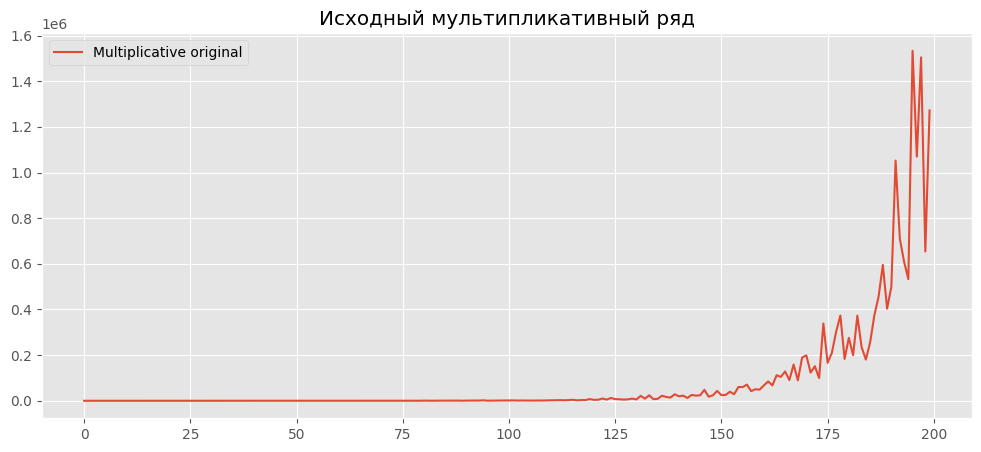

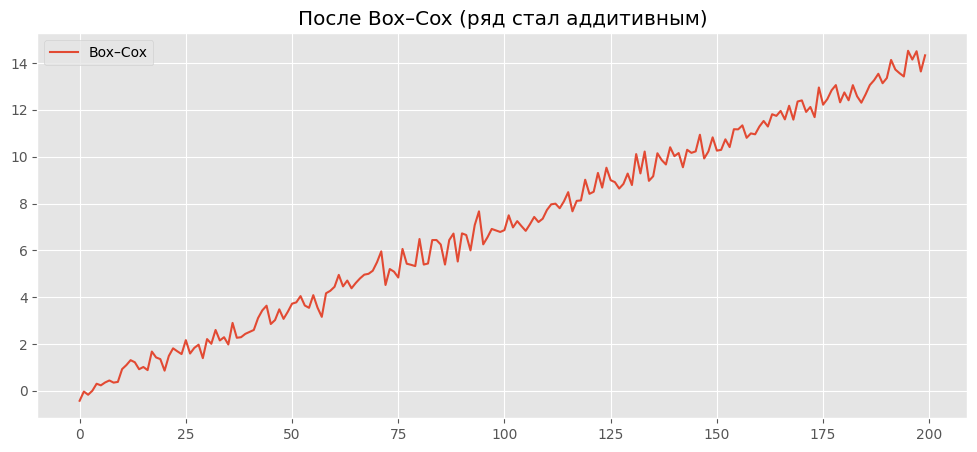

In [3]:
np.random.seed(322)

T = 200
t = np.arange(T)

trend = np.exp(0.07 * t)

sigma = 0.4
noise = np.exp(sigma * np.random.randn(T))

y = trend * noise
y = pd.Series(y, name='original')

y_bc, lam = boxcox(y)
print('Оценённая lam =', lam)
y_bc = pd.Series(y_bc, name='boxcox')

ets_mul = ExponentialSmoothing(y, trend='mul', seasonal='mul', seasonal_periods=20).fit()
ets_add = ExponentialSmoothing(y_bc,trend='add',seasonal='add',seasonal_periods=20).fit()

print('AIC:', ets_mul.aic)
print('SSE:', ets_mul.sse)

print('AIC:', ets_add.aic)
print('SSE:', ets_add.sse)

plt.figure(figsize=(12, 5))
plt.plot(y, label='Multiplicative original')
plt.title('Исходный мультипликативный ряд')
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(y_bc, label='Box–Cox')
plt.title('После Box–Cox (ряд стал аддитивным)')
plt.legend()
plt.show()